# Testing Sparse Zero-Inflated Count Matrix Factorization in simulated data 

In [1]:
from pCMF.misc import utils, plot_utils, print_utils
from pCMF.misc.model_wrapper import ModelWrapper
from pCMF.models.pcmf import pcmf
from pCMF.models.pcmf.inferences import cavi_new, svi_new

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd

from scipy.stats import gamma

import operator
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
# Experiment parameters
N = 1000 # number of observations
P = 100 # observation space dimensionality
K = 10 # latent space dimensionality
C = 2 # number of clusters

# Generate data set
z_p = 0.5
eps = 5.
Y, D, X, R, V, U, clusters = utils.generate_sparse_data(N, P, K, C=C, zero_prob=z_p, noisy_prop=0.5,
                                                 eps_U=eps, return_all=True)

Y_train, Y_test, X_train, X_test, D_train, D_test, U_train, U_test, c_train, c_test = train_test_split(Y, X, D, U.T, clusters, test_size=0.2, random_state=42)

In [3]:
labels_train = ['zero' if num==0 else 'um' for num in c_train]

In [4]:
T = 60. * 10.
S = 10.
max_iter = 1000000

In [5]:
# Run PCA
obj = PCA(n_components=K)
pca = ModelWrapper(np.log(Y_train + 1.), c_train, D_train=D_train, name='PCA')

In [6]:
pca.run(obj.fit_transform)

In [7]:
model1 = pcmf.PCMF(Y_train, c_train, X_test=Y_test, D_train=D_train, minibatch_size=1)
model2 = pcmf.PCMF(Y_train, c_train, X_test=Y_test, D_train=D_train, minibatch_size=10)
model3 = pcmf.PCMF(Y_train, c_train, X_test=Y_test, D_train=D_train, minibatch_size=100)
model4 = pcmf.PCMF(Y_train, c_train, X_test=Y_test, D_train=D_train, minibatch_size=500)

model_list = [model1, model2, model3, model4]

SVI-EB-1:
Considering zero-inflated counts.
Considering loading sparsity.
SVI-EB-10:
Considering zero-inflated counts.
Considering loading sparsity.
SVI-EB-100:
Considering zero-inflated counts.
Considering loading sparsity.
SVI-EB-500:
Considering zero-inflated counts.
Considering loading sparsity.


In [8]:
for model in model_list:
    model.run(max_iter=max_iter, verbose=True)

Running SVI-EB-1...
Iteration 1827/1000000. Log-likelihood: -1054.954. Elapsed: 0h1m0ss
Running SVI-EB-10...
Iteration 796/1000000. Log-likelihood: 119.383. Elapsed: 0h1m0ss
Running SVI-EB-100...
Iteration 175/1000000. Log-likelihood: 200.918. Elapsed: 0h1m0ss
Running SVI-EB-500...
Iteration 41/1000000. Log-likelihood: 218.085. Elapsed: 0h1m1ss


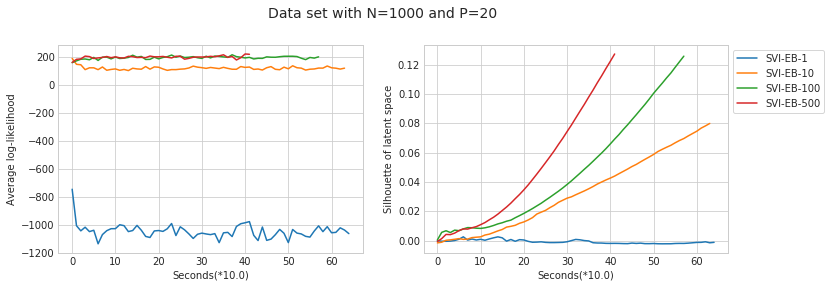

In [24]:
fig = plt.figure(figsize=(12, 4))

ax = plt.subplot(1, 2, 1)
plot_utils.plot_model_convergence(model_list, mode='ll_time', ax=ax, ylabel='Average log-likelihood', xlabel='Seconds(*{0})'.format(S))

ax = plt.subplot(1, 2, 2)
plot_utils.plot_model_convergence(model_list, mode='silh_time', ax=ax, ylabel='Silhouette of latent space', xlabel='Seconds(*{0})'.format(S))

plt.legend(loc='upper left', bbox_to_anchor=[1., 1.], frameon=True)
plt.suptitle('Data set with N={} and P={}'.format(N, P), fontsize=14)
plt.subplots_adjust(top=0.85)
#plt.show()
plt.savefig('../scripts/simulations/stochastic_vi/minibatch_variation/output/yo.png', bbox_inches='tight')

In [10]:
print_utils.print_model_lls(model_list, mode='Train')

Train data log-likelihood:
- SVI-EB-100: 198.688
- SVI-EB-500: 198.642
- SVI-EB-10: 118.037
- SVI-EB-1: -1053.98


In [11]:
print_utils.print_model_lls(model_list, mode='Test')

Test data log-likelihood:
- SVI-EB-500: 190.463
- SVI-EB-100: 190.459
- SVI-EB-10: 112.656
- SVI-EB-1: -1019.55


In [13]:
print_utils.print_model_silhouettes(model_list + [pca])

Silhouette scores:
- SVI-EB-100: 0.128257
- SVI-EB-500: 0.127317
- SVI-EB-10: 0.0801011
- PCA: 0.000970265
- SVI-EB-1: -0.000815359


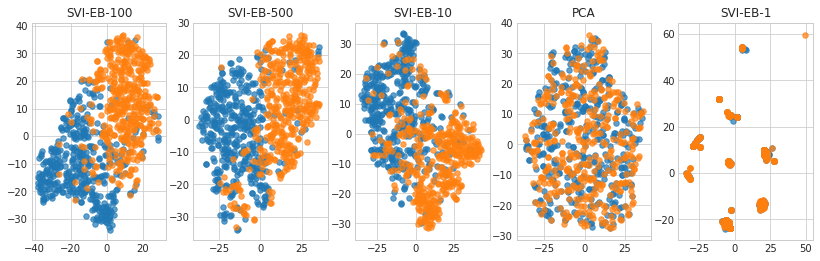

In [14]:
fig = plt.figure(figsize=(14, 4))
ax = plt.axes()
plot_utils.plot_sorted_tsnes(model_list + [pca], c_train, ax=ax, labels=labels_train, legend=False)

# Dropout identification and imputation
The held-out likelihood is only useful for data which isn't dominated by zeros. When it is, higher likelihoods will be obtained by models which place more mass at zero, which is not the comparison we want to make. In this case then, we evaluate the ability of the model to impute dropped out values.

We know what entries are dropouts because we have simulated them, and we also know the true value behind it.

First, we check if the model has identified dropouts well.

Then, we replace each dropout with the value the model finds to be most likely and compare it with the true value. For pCMF, imputing the entry $Y_{ij}$ corresponds to setting it to $U_iV_j $.

## Dropout identification

In [15]:
print_utils.print_model_dropid_acc(model_list)

Dropout identification accuracy:
- SVI-EB-100: 1.0
- SVI-EB-500: 1.0
- SVI-EB-10: 0.8005
- SVI-EB-1: 0.557813


## Dropout imputation 

In [16]:
print_utils.print_model_dropimp_err(model_list)

Dropout imputation error:
- SVI-EB-1: 2.37042
- SVI-EB-500: 63.3099
- SVI-EB-100: 69.6749
- SVI-EB-10: 115.564


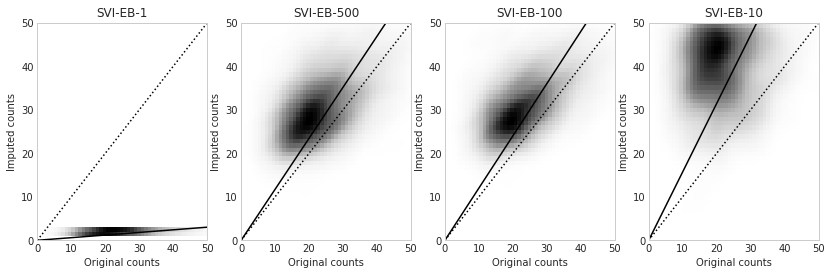

In [17]:
fig = plt.figure(figsize=(14, 4))
ax = plt.axes()
plot_utils.plot_sorted_imputation_densities(model_list, X_train, ax=ax, ymax=50)